A fully-connected neural network does a pretty good job here, because the spatial structure of the images is fairly simple.

pytorch on CPU

In [1]:
! pip install torch torchvision

pytorch on GPU

need for an older numpy version to use with the old pytorch version below (which is needed for GPU usage on my machine)

In [2]:
# ! pip install numpy==1.26.4

to use your GPU via CUDA:
- run the command nvidia-smi on terminal to find out your CUDA version, e.g., 11.6
- install the corresponding pytorch wheel (check here: https://pytorch.org/get-started/previous-versions/)
- need for a fitting python version (3.10 in my case)

In [3]:
# ! pip install torch==1.13.1+cu116 torchvision==0.14.1+cu116 --extra-index-url https://download.pytorch.org/whl/cu116

In [4]:
! pip install matplotlib
! pip install torcheval

In [5]:
import torch
from torchvision import datasets, transforms
from torcheval.metrics import MulticlassAccuracy
import numpy as np
import matplotlib.pyplot as plt

check for GPU and use it if available

In [6]:
if torch.cuda.is_available():
    dev = "cuda:0"
else:
    dev = "cpu"
device = torch.device(dev)
device

device(type='cpu')

In [7]:
transform = transforms.Compose([transforms.ToTensor()])

mnist_pytorch = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

mnist_pytorch

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [8]:
mnist_pytorch.data.shape

torch.Size([60000, 28, 28])

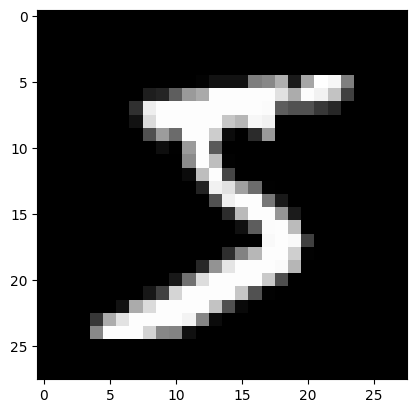

In [9]:
plt.imshow(mnist_pytorch.data[0], cmap='gray', vmin=0, vmax=255)

In [10]:
mnist_pytorch.targets

tensor([5, 0, 4,  ..., 5, 6, 8])

convert to one-hot targets for multi-classification

In [11]:
target_tensor = torch.nn.functional.one_hot(mnist_pytorch.targets).to(dtype=torch.float32).to(device)
target_tensor

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.]])

need to flatten 2D structure of image for fully-connected neural network

In [12]:
input_tensor = torch.flatten(mnist_pytorch.data, start_dim=1).to(dtype=torch.float32).to(device)

In [13]:
input_ds = torch.utils.data.TensorDataset(input_tensor, target_tensor)

split data in training and test sets

In [14]:
train_ds, test_ds = torch.utils.data.random_split(input_ds, [0.8, 0.2])

further split training set in training and validation sets

In [15]:
train_ds, val_ds = torch.utils.data.random_split(train_ds, [0.9, 0.1])

In [16]:
mini_batch_size = 512

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=mini_batch_size, shuffle=True, drop_last=False)
valid_dl = torch.utils.data.DataLoader(val_ds, batch_size=mini_batch_size * 2)

In [17]:
class FCN(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.fcn = torch.nn.Sequential(
            torch.nn.Linear(784, 500),
            torch.nn.ReLU(),
            torch.nn.Linear(500, 300),
            torch.nn.ReLU(),
            torch.nn.Linear(300, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, 10)
        )

    def forward(self, X):
        X = self.fcn(X)
        return X

In [18]:
model = FCN().to(device)
optimizer = torch.optim.Adam(model.parameters())

In [19]:
def fit(epochs, model, optimizer, train_dl, valid_dl=None):
    loss_func = torch.nn.CrossEntropyLoss()

    # loop over epochs
    for epoch in range(epochs):
        model.train()

        # loop over mini-batches
        for X_mb, y_mb in train_dl:
            y_hat = model(X_mb)

            loss = loss_func(y_hat, y_mb)
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()

        model.eval()
        with torch.no_grad():
            train_loss = sum(loss_func(model(X_mb), y_mb) for X_mb, y_mb in train_dl)
            valid_loss = sum(loss_func(model(X_mb), y_mb) for X_mb, y_mb in valid_dl)
        print('epoch {}, training loss {}'.format(epoch + 1, train_loss / len(train_dl)))
        print('epoch {}, validation loss {}'.format(epoch + 1, valid_loss / len(valid_dl)))

    print('Finished training')

    return model

In [20]:
epochs = 50

trained_model = fit(epochs, model, optimizer, train_dl, valid_dl)

epoch 1, training loss 0.1528824269771576
epoch 1, validation loss 0.19657738506793976
epoch 2, training loss 0.08492693305015564
epoch 2, validation loss 0.13951745629310608
epoch 3, training loss 0.05417836084961891
epoch 3, validation loss 0.13203993439674377
epoch 4, training loss 0.05051407963037491
epoch 4, validation loss 0.12554514408111572
epoch 5, training loss 0.019923536106944084
epoch 5, validation loss 0.11361279338598251
epoch 6, training loss 0.02703625150024891
epoch 6, validation loss 0.13683342933654785
epoch 7, training loss 0.020661544054746628
epoch 7, validation loss 0.13842910528182983
epoch 8, training loss 0.016069643199443817
epoch 8, validation loss 0.1416979879140854
epoch 9, training loss 0.010608822107315063
epoch 9, validation loss 0.12390214204788208
epoch 10, training loss 0.02728930674493313
epoch 10, validation loss 0.14342045783996582
epoch 11, training loss 0.015288816764950752
epoch 11, validation loss 0.14558497071266174
epoch 12, training loss 0

In [21]:
def evaluation(ds, model):
    with torch.no_grad():
        preds = model(ds[:][0]).cpu()

    # take output node with highest probability
    yhat = np.argmax(preds, axis=1)
    y = ds[:][1].cpu()

    # from one-hot back to labels
    y = torch.argmax(y, dim=1)

    metric = MulticlassAccuracy()

    metric.update(yhat, y)
    return metric.compute()

In [22]:
evaluation(train_ds, trained_model)

tensor(0.9951)

In [23]:
evaluation(test_ds, trained_model)

tensor(0.9714)